# Pryngles module: System

In [1]:
from pryngles import *

## External modules

In [2]:
import rebound as rb
from tqdm import tqdm

## Aliases

In [3]:
sci=Science
print_df=Misc.print_df

## System Class

This is the most important class in the whole package.  This class allows to create the planetary system and manipulate it.

In [4]:
System_doc=\
f"""Creates a planetary system.

    Initialization attributes:

        units: list of strings, default = ['au','msun','yr']:
            Units used in calculations following the conventions and signs of rebound.
            The order SHOULD always be MKS: length, mass, time (in that order)

    Optional attributes:

        resetable: boolean, default = False:
            If True the system is resetable, namely you can reset it to the initial system.
            
        filename: string, default = None:
            File to load system.

    Derived attributes:

        sim: Class Simulation:
            Rebound Simulation object.

        ul, um, ut: float [SI units]:
            Value of the conversion factors for each unit.

        G: float [ul^3/ut^2/um]
            Value of the gravitational constant.

        bodies: dictionary:
            Bodies in the system.

        sources: dictionary:
            Bodies in the system which are sources of light.

        nbodies: int:
            Number of bodies.

        nsources: int:
            Number of sources of light.

        nparticles: int:
            Numbre of particles in rebound simulation.

        spangler: Class Spangler:
            Spangler object with all the spangles in the system.

    Examples:

        #Create a system
        sys=System(units=["au","msun","yr"])
        sys.sim.integrator='whfast'
        sys.sim.dt=0.01

        #Add star (by default, m = 1)
        S=sys.add()

        #Add planet, when an object is added, it is automatically spangled
        P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

        #Add moon: orbital elements are respect to ecliptic system
        M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

        #Add ring system
        R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

""";

In [5]:
class System(PrynglesCommon):
    
    def __init__(self,
                 filename=None,
                 units=['au','msun','yr'],
                 resetable=False
                ):
        
        if filename:
            self.load_from(filename)
            return
        
        #Rebound simulation
        self.sim=rb.Simulation()
        
        #Attributes by default
        self.bodies=dict()
        self.sources=dict()
        
        #Observer properties
        self.n_obs=[0,0,1]
        self.alpha_obs=0  
        
        #Check if spangled
        self._spangled=False

        #Initialize spangler object
        self.sg=None
        
        #Is the system resetable?
        self._resetable=resetable
        if self._resetable:
            #Create temporary file
            self._snap_file_name = "/tmp/pryngles-system.pkl"
        
        #Update rebound units
        self.update_units(units)
        
    def update_units(self,units):
        """Update units of the system
        """
        self.units=units
        
        #Units
        self._ul,self._um,self._ut=self.units
        self.sim.units=self.units
        
        #Canonical units of the system
        self.ul=rb.units.convert_length(1,self._ul,"m")
        self.um=rb.units.convert_mass(1,self._um,"kg")
        self.ut=np.sqrt(self.sim.G*self.ul**3/(self.um*GSI))
        
        #Update system
        self._update_system()
        
    def _get_source(self,body):
        """Get the source of light (stellar body) in the center of a body
        """
        if (body.primary is None) or (body.kind == "Star"):
            return body

        elif body.primary.kind == "Star":
            return body.primary

        else:
            return self._get_source(body.primary)

    def _update_system(self):
        """Update system properties
        """
        self.nbodies=len(self.bodies)
        self.nsources=len(self.sources)
        self.nparticles=len(self.sim.particles)
        
    def _is_spangled(self):
        return True if self.sg else False
        
    def save_to(self,filename):
        """Save system from file
        
        Parameters:
            filename: string:
                Path to file where the object will be pickled.
                
        Result:
            File 'filename' for regular object and 'filename.rbin' for rebound simulation
        """
        #Rebound file
        rb_filename=filename+".rbin"

        #Save rebound state
        verbose(VERB_SIMPLE,"Saving rebound simulation")
        self.sim.save(rb_filename)

        #Since rebound have ctypes it cannot be pickled
        del self.sim

        #Pickle system
        PrynglesCommon.save_to(self,filename)

        #Load again rebound
        self.sim=rb.Simulation(rb_filename)

    def load_from(self,filename):
        """Load system from filename
                
        Parameters:
            filename: string:
                Path to file where the object will be pickled.
                There to be 2 files: 'filename' (with the regular object) and filename.rbin with 
                rebound simulation.
        """
        #Rebound file
        rb_filename=filename+".rbin"

        #Load system
        self=PrynglesCommon.load_from(self,filename)

        #Load rebound
        verbose(VERB_SIMPLE,"Loading rebound simulation")
        self.sim=rb.Simulation(rb_filename)
        
    def status(self):
        print(f"System with {self.nbodies} bodies, {self.nsources} sources and {self.nparticles} particles")
        sys.sim.status()

System.__doc__=System_doc

In [6]:
if IN_JUPYTER:
    def test_system_init(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System(resetable=True)
        print("Nbodies = ",sys.nbodies)
        print("G constant = ",sys.sim.G)
        print("G constant = ",sys.units)
        print("Canonical units = ",sys.ul,sys.um,sys.ut)
        
        sys=System(units=['m','kg','s'])
        print("Nbodies = ",sys.nbodies)
        print("G constant = ",sys.sim.G)
        print("G constant = ",sys.units)
        print("Canonical units = ",sys.ul,sys.um,sys.ut)
        print(sys)
        
        sys.save_to("/tmp/system.pkl")
        print(sys.sim.status())
        sys2=System("/tmp/system.pkl")
        print(sys2.sim.status())
        
        print(sys.sim.N)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_system_init=test_system_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

Nbodies =  0
G constant =  39.476926421373
G constant =  ['au', 'msun', 'yr']
Canonical units =  149597870700.0 1.9884754159665356e+30 31557600.0
Nbodies =  0
G constant =  6.67408e-11
G constant =  ['m', 'kg', 's']
Canonical units =  1.0 1.0 1.0
{'sim': <rebound.simulation.Simulation object at 0x7fbe5b6de3c0, N=0, t=0.0>, 'bodies': {}, 'sources': {}, 'n_obs': [0, 0, 1], 'alpha_obs': 0, 'sg': None, 'units': ['m', 'kg', 's'], 'ul': 1.0, 'um': 1.0, 'ut': 1.0, 'nbodies': 0, 'nsources': 0, 'nparticles': 0}
  VERB1::save_to:: Saving rebound simulation
    VERB2::save_to:: Saving object to /tmp/system.pkl
---------------------------------
REBOUND version:     	3.19.3
REBOUND built on:    	May  7 2022 18:49:54
Number of particles: 	0
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
None
    VERB2::load_from:: Loading object from /tmp/system.pkl
      VERB3::load_from:: Transferring data to new object
  VE


----------------------------------------------------------------------
Ran 1 test in 0.150s

OK


In [7]:
def add(self,kind="Star",primary=None,**props):
    """Add an object to the system
    
    Examples:
    
        sys=System()
        S=sys.add("Star",m=2)
    
    Parameters:
    
        kind: string, default = "Star":
            Kind of object: Star, Planet, Ring (see BODY_KINDS).
    
        primary: Body, default = None:
            Primary object of the body.
            
        props: dictionary:
            List of properties of the body.
            
    Returns:
        
        Body
            Body added to the system.
            
    Examples:
        #Add star (by default, m = 1)
        S=sys.add()

        #Add planet, when an object is added, it is automatically spangled
        P=sys.add("Planet",radius=0.1,m=1e-3,x=1,vy=0.2)

        #Add moon: orbital elements are respect to ecliptic system
        M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

        #Add ring system
        R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)        
        
    """
    if kind is None:
        raise AssertionError("You must provide a valid object kind (Star, Planet, Ring).")

    if kind not in BODY_KINDS:
        raise ValueError(f"Object kind '{kind}' is not recognized.")

    #Create body
    exec(f"self.__body={kind}(primary=primary,**props)")
    
    if self.__body.bhash in self.bodies:
        raise ValueError(f"An object with hash '{self.__body.bhash}' has been already added.")
    
    self.bodies[self.__body.bhash]=self.__body
    
    if kind == "Star":
        #Add a source
        self.sources[self.__body.bhash]=self.__body
    
    if kind == "Ring":
        
        #If it is a ring it does not need to be add to rebound
        self.__body.rbhash=self.__body.primary.rbhash
    
    else:
        
        #Add body to simulation
        rb_add_options={k:v for k,v in self.__body.__dict__.items() if k in REBOUND_ORBITAL_PROPERTIES}
        rb_add_options.update(hash=self.__body.bhash)
        
        verbose(VERB_VERIFY,f"Adding rebound object with hash {self.__body.bhash}")
        verbose(VERB_DEEP,f"Rebound add options {rb_add_options}")
        
        #Add particle to rebound
        self.sim.add(**rb_add_options)
        
        #self.__body.particle=self.sim.particles[self.__body.hash] <- This is not convenient for pickling
        self.__body.rbhash=self.__body.bhash

    verbose(VERB_SIMPLE,f"Object '{kind}' with hash '{self.__body.bhash}' has been added.")
    #Update system
    self._update_system()
    return self.__body
    
System.add=add

In [8]:
if IN_JUPYTER:
    def test_system_add(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        S=sys.add(m=8,radius=4,x=5,vy=2)
        P=sys.add("Planet",primary=S,radius=2,x=1)
        M=sys.add("Planet",primary=P,radius=2,x=2)
        R=sys.add("Ring",primary=P,fi=1.3,fe=2.3)
        
        for particle in sys.sim.particles:
            print(particle)
            
        print(sys)
        print(sys.nbodies,sys.nparticles,sys.nsources)

        Verbose.VERBOSITY=VERB_NONE
                
    class Test(unittest.TestCase):pass    
    Test.test_system_add=test_system_add
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [], N = 3.141592653589793
      VERB3::add:: Adding rebound object with hash 8778472154438
        VERB4::add:: Rebound add options {'m': 8, 'x': 5, 'y': 0, 'z': 0, 'vx': 0, 'vy': 2, 'vz': 0, 'hash': '8778472154438'}
  VERB1::add:: Object 'Star' with hash '8778472154438' has been added.
      VERB3::_update_childs:: Add child 8778472154507 to body Star (8778472154438)
      VERB3::_update_primary:: Add primary 8778472154438 to body Planet (8778472154507)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties::

.

      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::add:: Adding rebound object with hash 8778472154504
        VERB4::add:: Rebound add options {'m': 1, 'x': 2, 'y': 0, 'z': 0, 'vx': 0, 'vy': 0, 'vz': 0, 'hash': '8778472154504'}
  VERB1::add:: Object 'Planet' with hash '8778472154504' has been added.
      VERB3::_update_childs:: Add child 8778472154477 to body Planet (8778472154507)
      VERB3::_update_primary:: Add primary 8778472154507 to body Ring (8778472154477)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_ring:: Updating Ring
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_ring_properties:: Updating Ring properties
  VERB1::add:: Object 'Ring' with hash '8778472154477' has been added.
<rebound.particle.Particle object at 0x7fbe59f65ac0, m=8.0 x=5.0 y=0.0 z=0.0 vx=0.0 vy=2.0 vz=0.0>
<rebound.particl


----------------------------------------------------------------------
Ran 1 test in 0.324s

OK


In [9]:
def remove(self,bhash):
    """Remove a body from a system.

    Parameters:
        bhash: string
            Hash of the body to remove
    
    Notes: 
        Remove eliminate body and all the childs and the childs of the childs.

    Example:
        sys=System()
        S=sys.add(m=2)
        sys.remove(bhash=S.bhash)
    """
    
    if bhash in self.bodies:
        verbose(VERB_SIMPLE,f"Removing object {bhash} from system")

        obj=self.bodies[bhash]

        #Get the list of child hashes before removing (it changes during for)
        child_hashes=list(obj.childs.keys())
        
        #Remove child objects
        for child_hash in child_hashes:
            if child_hash in self.bodies:
                self.remove(child_hash)
                
        #Remove object from simulation
        if obj.kind != "Ring":
            verbose(VERB_SIMPLE,f"Removing particle {bhash} from simulation")
            self.sim.remove(hash=bhash)
        
        #Remove object from childs of its primary
        if obj.primary:
            del obj.primary.childs[bhash]
        
        #Remove object from bodies
        del self.bodies[bhash]

        #Update system
        self._update_system()
    else:
        raise ValueError(f"No object with hash '{bhash}' in the system")

System.remove=remove

In [10]:
if IN_JUPYTER:
    def test_system_remove(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        S=sys.add(bhash="Star",m=8,radius=4,x=5,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",radius=2,x=2)
        M=sys.add("Planet",primary=P,bhash="Moon",radius=2,x=2)
        R=sys.add("Ring",primary=P,bhash="Ring",fi=1.3,fe=2.3)
        print(sys.bodies)
        sys.remove("Ring")
        print(sys.bodies)
        sys.remove("Planet")
        print(sys.bodies)
        sys.remove("Star")
        print(sys.bodies)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_system_remove=test_system_remove
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::add:: Adding rebound object with hash Star
        VERB4::add:: Rebound add options {'m': 8, 'x': 5, 'y': 0, 'z': 0, 'vx': 0, 'vy': 2, 'vz': 0, 'hash': 'Star'}
  VERB1::add:: Object 'Star' with hash 'Star' has been added.
      VERB3::_update_childs:: Add child Planet to body Star (Star)
      VERB3::_update_primary:: Add primary Star to body Planet (Planet)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::add:: Adding rebound object with hash Planet
        VERB4::add:: Rebound add options {'m': 1, 'x': 2, 'y': 0, 'z': 0, 'vx':

/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: Last particle removed.
  warnings.warn(msg[1:], RuntimeWarning)
.

      VERB3::add:: Adding rebound object with hash Moon
        VERB4::add:: Rebound add options {'m': 1, 'x': 2, 'y': 0, 'z': 0, 'vx': 0, 'vy': 0, 'vz': 0, 'hash': 'Moon'}
  VERB1::add:: Object 'Planet' with hash 'Moon' has been added.
      VERB3::_update_childs:: Add child Ring to body Planet (Planet)
      VERB3::_update_primary:: Add primary Planet to body Ring (Ring)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_ring:: Updating Ring
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_ring_properties:: Updating Ring properties
  VERB1::add:: Object 'Ring' with hash 'Ring' has been added.
{'Star': <pryngles.body.Star object at 0x7fbe5b416af0>, 'Planet': <pryngles.body.Planet object at 0x7fbe48762520>, 'Moon': <pryngles.body.Planet object at 0x7fbe5b416df0>, 'Ring': <pryngles.body.Ring object at 0x7fbe5b6f2760>}
  VERB1::remove:: Removi


----------------------------------------------------------------------
Ran 1 test in 0.357s

OK


## Spangle System

In [90]:
def spangle_system(self):
    """Generate the spangles of the objects in the system
    
    Attributes created:
        
        spanglers: dictionary of Spangler objects:
            Spangler corresponding to each object in the system.
            
        sp: Spangler:
            Spangler corresponding to all system.
            
    Result:
        
        This method create the spangler of the system

    """
    
    self._spanglers=dict()
    source=1
    for bhash,body in self.bodies.items():
        
        verbose(VERB_SIMPLE,f"Spangling body '{bhash}' (kind '{body.kind}')")
        body.spangle_body()

        if body.kind=="Star":
            body.sg.data.source=source
            source+=1
        
        #Center object around its position according to rebound
        body.center_ecl=np.array(self.sim.particles[body.rbhash].xyz)
        body.sg.set_positions(center_ecl=body.center_ecl)
            
        self._spanglers[bhash]=body.sg
    
    #Join spanglers
    self.sg=Spangler(spanglers=list(self._spanglers.values()))
    
    #Add column for controlling information on sources
    for source in range(1,self.nsources+1):
        for source_state in SPANGLER_SOURCE_STATES.keys():
            self.sg.data[source_state+f"_{source}"]=0
    
    #Set default observer
    self.set_observer(nvec=self.n_obs,alpha=self.alpha_obs)
    
    #Set light sources
    self.set_luz()
    
    #Save state of the system
    if self._resetable:
        self.save_to(self._snap_file_name)
    
    #Already spangled
    self._spangled=True

System.spangle_system=spangle_system

2
{'Star2': <pryngles.body.Star object at 0x7fbdf07f4e50>, 'Star1': <pryngles.body.Star object at 0x7fbe4a544820>}
Index(['sphash', 'spangle_type', 'geometry', 'scale', 'n_equ', 'alpha_equ',
       'w', 'q0', 'center_equ', 'x_equ', 'y_equ', 'z_equ', 'r_equ', 'q_equ',
       'f_equ', 'ns_equ', 'center_ecl', 'x_ecl', 'y_ecl', 'z_ecl', 'ns_ecl',
       'center_int', 'x_int', 'y_int', 'z_int', 'ns_int', 'rho_int', 'az_int',
       'cost_int', 'cos_int', 'd_int', 'z_cen_int', 'center_obs', 'x_obs',
       'y_obs', 'z_obs', 'ns_obs', 'rho_obs', 'az_obs', 'cost_obs', 'cos_obs',
       'd_obs', 'z_cen_obs', 'center_luz', 'x_luz', 'y_luz', 'z_luz', 'ns_luz',
       'rho_luz', 'az_luz', 'cost_luz', 'cos_luz', 'd_luz', 'z_cen_luz', 'asp',
       'dsp', 'albedo_gray_normal', 'tau_gray_optical', 'unset', 'hidden',
       'source', 'visible', 'intersect', 'shadow', 'indirect', 'emit', 'above',
       'illuminated', 'transmit', 'transit', 'occult', 'illuminated_1',
       'transmit_1', 'transit_1', '

<IPython.core.display.Javascript object>


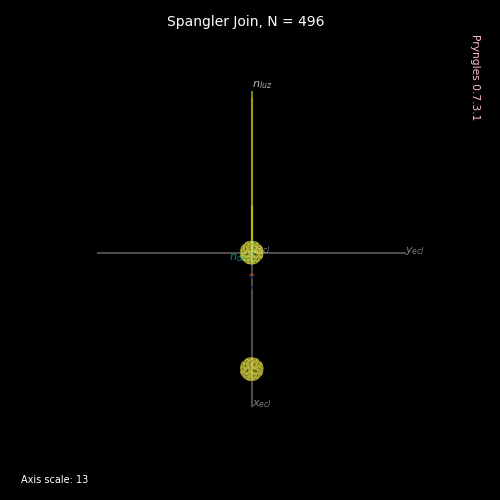

.
----------------------------------------------------------------------
Ran 1 test in 0.702s

OK


In [91]:
if IN_JUPYTER:
    def test_spangle(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=False)
        S2=sys.add(bhash="Star2",nspangles=nspangles,m=8,radius=1,x=10,vy=-2)
        S1=sys.add(bhash="Star1",nspangles=nspangles,m=9,radius=1,x=0,vy=+2)
        P=sys.add("Planet",primary=S1,bhash="Planet",nspangles=nspangles,radius=0.2,x=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,x=3)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        
        sys.spangle_system()
        
        #Check addition columns
        print(sys.nsources)
        print(sys.sources)
        print(sys.sg.data.columns)
        
        #Check save
        sys.save_to("/tmp/system.pkl")
        
        #Check plot
        #sys.sp.plot3d(center_at="Ring",not_plot=["Star1","Star2"])
        sys.sg.plot3d()

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_spangle=test_spangle
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Miscelaneous methods

In [92]:
def update_body(self,body,**props):
    """Update properties of a body in the system
    
    Parameters:
        body: string or Body:
            Body to update
        
        props: dict:
            Dictionary with properties of the object
    """
    #Update spangling?
    if self._is_spangled():
        raise AssertionError("After spangling you cannot update the properties of the bodies.  Please rebuild the system")

    #Update body properties
    if isinstance(body,Body):
        body.update_body(**props)
    elif body in self.bodies:
        body=self.bodies[body]
        lkind=body.kind.lower()
        exec(f"body.update_{lkind}()")
    else:
        raise AssertionError("You are trying to update a body ({body}) which is not in the system")
        
    #Check if among props there is any property related to position
    if any(k in props for k in REBOUND_ORBITAL_PROPERTIES):
        raise ValueError(f"You cannot update an orbital property {props} without compromising the full simulation. Rebuild the system from scratch.")
        
System.update_body=update_body

In [93]:
if IN_JUPYTER:
    def test_update(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=True)
        S=sys.add("Star",bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,x=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,x=3)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        print(P.radius)
        sys.update_body(P,radius=0.5)
        print(P.radius)
        sys.update_body("Ring",fe=3.0)
        print(R.radius)
        sys.spangle_system()
        self.assertRaises(AssertionError,lambda:sys.update_body("Ring",fe=3.0))

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_update=test_update
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

0.2
0.5
1.15


.
----------------------------------------------------------------------
Ran 1 test in 0.408s

OK


In [94]:
def set_observer(self,nvec=[0,0,1],alpha=0,center=None):
    """Set the position of the observer
    """
    #Only set observer if it is spangled
    self.alpha_obs=alpha
    self.center_obs=center
    
    if self._is_spangled():
        
        #Set observer
        self.sg.set_observer(nvec=nvec,alpha=self.alpha_obs,center=self.center_obs)
        self.d_obs=self.sg.d_obs
        self.n_obs=self.sg.n_obs.copy()
        self.rqf_obs=self.sg.rqf_obs.copy()
        
        #Update visibility
        self.sg.update_visibility_state()
        
    else:
        raise AssertionError("You must first spangle system before setting observer direction.")
        
System.set_observer=set_observer

<IPython.core.display.Javascript object>


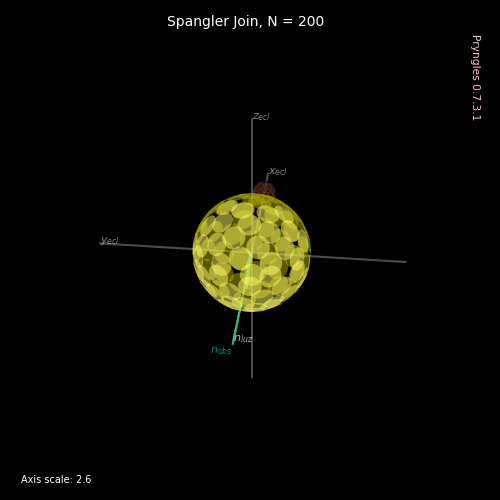

<IPython.core.display.Javascript object>


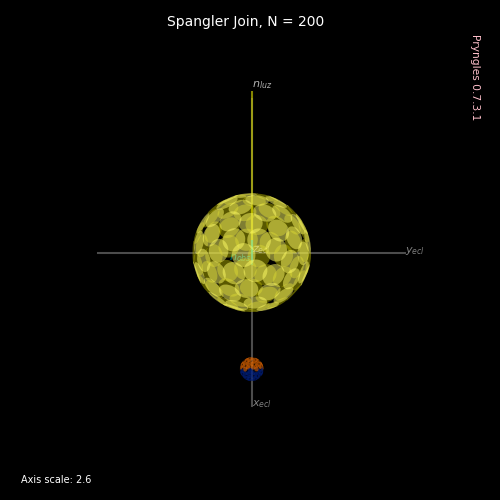

.
----------------------------------------------------------------------
Ran 1 test in 0.428s

OK


In [95]:
if IN_JUPYTER:
    def test_obs(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        
        #Define system
        sys=System(resetable=True)
        
        #Add objects
        S=sys.add(bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,x=2)
        
        #Test setting observer without spangling
        self.assertRaises(AssertionError,lambda:sys.set_observer(nvec=[1,0,0]))
        
        #Spangle system
        sys.spangle_system()
        
        sys.set_observer(nvec=[-1,0,0])
        sys.sg.plot3d()
        
        sys.set_observer(nvec=[0,0,1])
        sys.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_obs=test_obs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [96]:
def reset(self):
    """Reset system to spangling state
    """
    if self._resetable:
        self.load_from(self._snap_file_name)
        pass
    else:
        print("System is not resetable. Use resetable = True when defining the System or when you spangle it.")
    
System.reset=reset

<IPython.core.display.Javascript object>


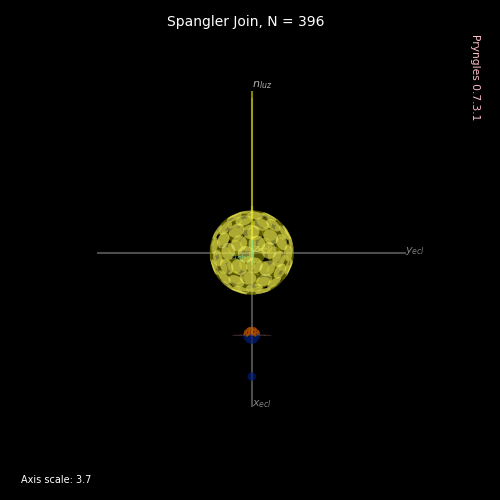

<IPython.core.display.Javascript object>


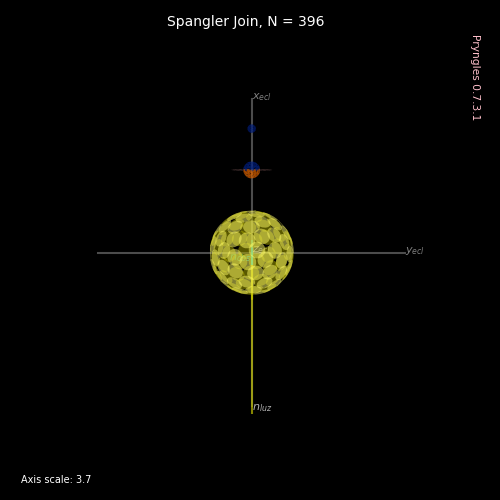

<IPython.core.display.Javascript object>


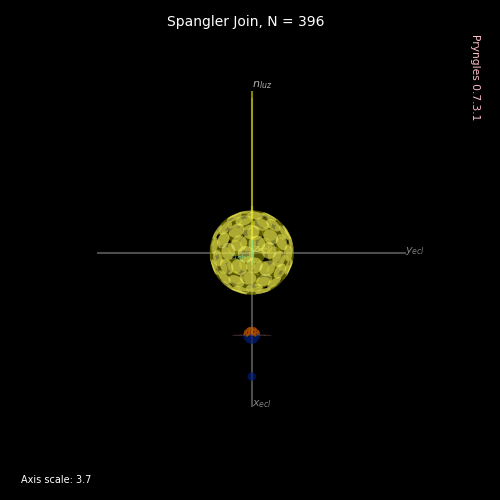

.
----------------------------------------------------------------------
Ran 1 test in 1.039s

OK


In [97]:
if IN_JUPYTER:
    def test_reset(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System(resetable=True)
        S=sys.add("Star",bhash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,x=2)
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,x=3)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        sys.spangle_system()

        #All transformations from here are not stored
        sys.sg.plot3d()
        sys.set_observer(nvec=[0,0,-1])
        sys.sg.plot3d()

        #All transformations from here are not stored
        sys.reset()
        sys.sg.plot3d()

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_reset=test_reset
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Set luz

In [98]:
def set_luz(self):
    """Set light in the system
    """
    if self._is_spangled():
        
        for bhash,body in self.bodies.items():
            
            if body.kind == "Star":
                continue
                 
            #Get center of body
            center=body.center_ecl
                    
            #Get source and center
            source=self._get_source(body)
            center_source=source.center_ecl
            
            verbose(VERB_VERIFY,f"Calculating illumination for '{bhash}' coming from '{source.bhash}' @ {center_source}")
            
            #Get direction of light
            nluz=center_source-center
            
            #Set light for this body
            self.sg.set_luz(nvec=nluz,center=center_source,sphash=bhash)
            self.sg.update_illumination_state()
            
    else:
        raise AssertionError("You must first spangle system before setting light.")
        
System.set_luz=set_luz

<IPython.core.display.Javascript object>


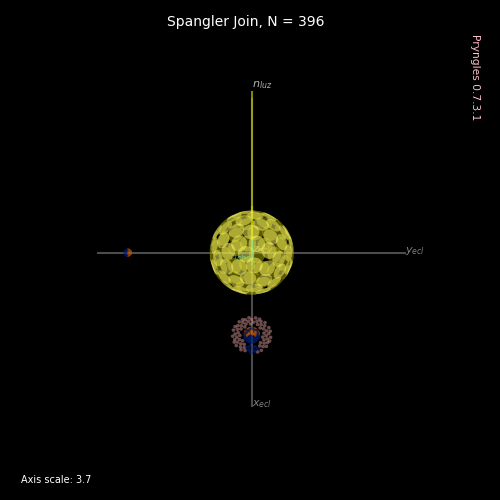

.
----------------------------------------------------------------------
Ran 1 test in 0.531s

OK


In [99]:
if IN_JUPYTER:
    def test_setluz(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System()
        S=sys.add("Star",bhash="Star",nspangles=nspangles,m=1,radius=1,x=0,y=0,vy=0)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,m=1e-3,
                  x=2,vy=np.sqrt(sys.sim.G/2))
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,m=1e-6,
                  x=0,y=-3,vx=np.sqrt(sys.sim.G/3),vy=0)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=20*Consts.deg)
        sys.spangle_system()

        sys.set_observer([0,0,1])
        sys.set_luz()
        
        sys.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_setluz=test_setluz
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

## Integrate system

In [100]:
def integrate(self,*args,**kwargs):
    """Integrate system

    Parameters:
        *args, **kwargs:
            Mandatory (non-keyword) arguments and optional (keyword) arguments for rebound.integrate.
        
    Update:
        Integrate using integrate rebound method.
        
        Update center of each body and set positions of the spangles.
    """
    #Time of integration
    t=args[0]
    verbose(VERB_SIMPLE,"Integrating up to {t}")
    
    if self._is_spangled():
        
        #Integrate
        self.sim.integrate(*args,**kwargs)
        self.sim.move_to_com()
    
        #Update positions
        for bhash,body in self.bodies.items():
            
            #Position of the body according
            body.center_ecl=np.array(self.sim.particles[body.rbhash].xyz)

            verbose(VERB_VERIFY,f"Updating center of body {bhash} @ {body.center_ecl}")
            cond=self.sg.data.sphash==bhash
            self.sg.data.loc[cond,"center_ecl"]=pd.Series([list(body.center_ecl)]*sum(cond),dtype=object).values

        #Update positions
        self.sg.set_positions()
        
    else:
        raise AssertionError("You must first spangle system before setting positions.")
    
System.integrate=integrate

<IPython.core.display.Javascript object>


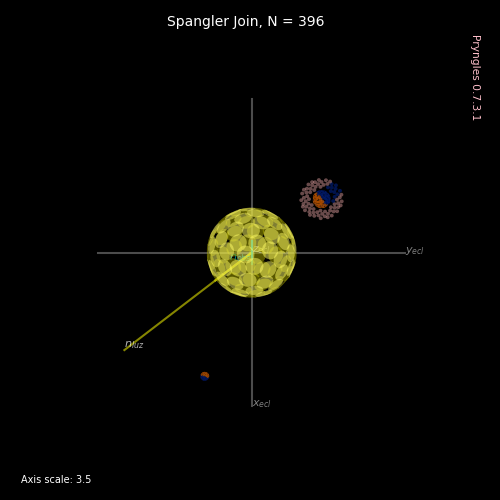

.
----------------------------------------------------------------------
Ran 1 test in 0.555s

OK


In [101]:
if IN_JUPYTER:
    def test_int(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System()
        S=sys.add("Star",bhash="Star",nspangles=nspangles,m=1,radius=1,x=0,y=0,vy=0)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,m=1e-3,
                  x=2,vy=np.sqrt(sys.sim.G/2))
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,m=1e-6,
                  x=0,y=-3,vx=np.sqrt(sys.sim.G/3),vy=0)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=20*Consts.deg)
        sys.spangle_system()

        sys.integrate(1)
        
        sys.set_observer([0,0,1])
        sys.set_luz()
        
        sys.sg.plot3d()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_int=test_int
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [102]:
def animate_integration(self,filename=None,tini=0,tend=2*np.pi,nsnap=10,interval=100,coords="obs"):

    verbosity=Verbose.VERBOSITY
    Verbose.VERBOSITY=VERB_NONE
    
    self.sg.fig2d=None
    self.sg.plot2d(coords=coords,axis=False)
    camera=Camera(self.sg.fig2d)
    
    for t in tqdm(np.linspace(tini,tend,nsnap)):
        self.integrate(t)
        self.set_observer(nvec=self.n_obs)
        self.set_luz()
        self.sg.plot2d(coords=coords,axis=False)
        camera.snap()
    
    anim=camera.animate(interval=interval)
    
    Verbose.VERBOSITY=verbosity
    
    if filename is not None:
        if 'gif' in filename:
            anim.save(filename)
            return anim
        elif 'mp4' in filename:
            ffmpeg=animation.writers["ffmpeg"]
            metadata = dict(title='Pryngles Spangler Animation',
                            artist='Matplotlib',
                            comment='Movie')
            w=ffmpeg(fps=15,metadata=metadata)
            anim.save(filename,w)
            return anim
        else:
            raise ValueError(f"Animation format '{filename}' not recognized")
    else:
        return anim
    
System.animate_integration=animate_integration

<IPython.core.display.Javascript object>


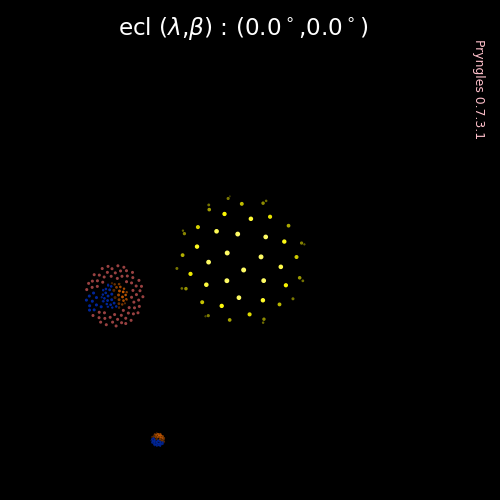

100%|██████████| 5/5 [00:00<00:00,  7.41it/s]
.
----------------------------------------------------------------------
Ran 1 test in 1.225s

OK


In [68]:
if IN_JUPYTER:
    def test_anim(self):
        
        global sys
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=100
        sys=System()
        S=sys.add("Star",bhash="Star",nspangles=nspangles,m=1,radius=1,x=0,y=0,vy=0)
        P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,radius=0.2,m=1e-3,
                  x=2,vy=np.sqrt(sys.sim.G/2))
        M=sys.add("Planet",primary=P,bhash="Moon",nspangles=nspangles,radius=0.1,m=1e-6,
                  x=0,y=-3,vx=np.sqrt(sys.sim.G/3),vy=0)
        R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=20*Consts.deg)
        sys.spangle_system()

        sys.animate_integration(filename="/tmp/pryngles-dynamics.gif",tini=0,tend=10,interval=1000,nsnap=5,coords="ecl")
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_anim=test_anim
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--

<IPython.core.display.Javascript object>


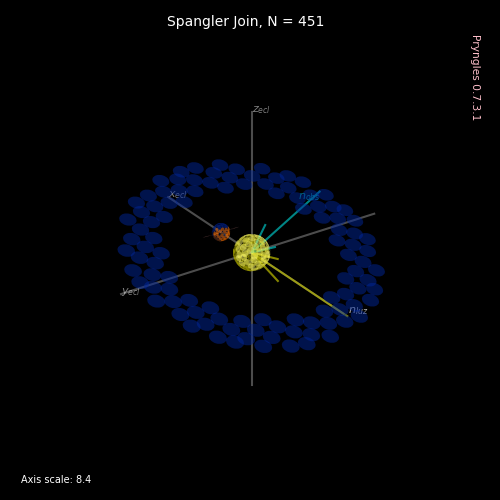

In [127]:
nspangles=100

sys=System()
S=sys.add("Star",bhash="Star",nspangles=nspangles,m=1,radius=1,x=0,y=0,vy=0)
R=sys.add("Ring",primary=S,bhash="Disk",nspangles=nspangles,
          fi=5,fe=7,i=20*Consts.deg,roll=180*Consts.deg)
P=sys.add("Planet",primary=S,bhash="Planet",nspangles=nspangles,
          m=1e-3,radius=0.5,x=3,vy=np.sqrt(sys.sim.G/1))
R=sys.add("Ring",primary=P,bhash="Ring",nspangles=nspangles,
          fi=1.5,fe=2,i=30*Consts.deg,roll=0*Consts.deg)
sys.spangle_system()

sys.set_observer(nvec=[-1,0,1])
sys.set_luz()
sys.sg.plot3d()

<IPython.core.display.Javascript object>


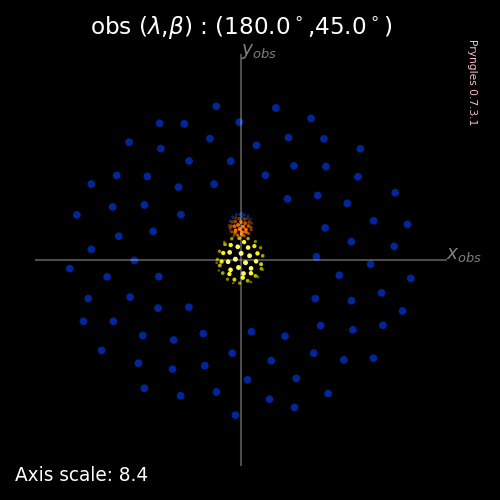

In [121]:
sys.sg.plot2d()

In [129]:
print_df(sys.sg.data)

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult,illuminated_1,transmit_1,transit_1,occult_1
0,Star,6,1,1.0,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",1.271940e-01,-6.100572e-02,-0.990,1.000000,5.835968,-1.429257,"[0.12719395512303389, -0.06100571924139298, -0.99]","[0.0, 0.0, 0.0]",6.100572e-02,1.271940e-01,-9.900000e-01,"[0.06100571924139292, 0.12719395512303389, -0.99]","[0.0, 0.0, 0.0]",-1.271940e-01,-9.900000e-01,-6.100572e-02,"[-0.12719395512303389, -0.99, -0.06100571924139292]",0.998137,4.584610e+00,-6.100572e-02,-0.061006,1.000000,0.0,"[0.0, 0.0, 0.0]",-1.271940e-01,-6.568982e-01,-7.431733e-01,"[-0.12719395512303389, -0.6568981556079305, -0.7431732711414336]",0.669099,4.521128,-7.431733e-01,-0.743173,inf,-inf,"[0.0, 0.0, 0.0]",6.100572e-02,1.271940e-01,-0.990000,"[0.06100571924139292, 0.12719395512303389, -0.99]",0.141067,1.123579e+00,-0.990000,-0.743173,inf,-inf,0.125664,0.400000,1.0,0.0,False,False,1,False,False,False,False,False,False,True,False,False,False,0,0,0,0
1,Star,6,1,1.0,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-9.061259e-02,2.255867e-01,-0.970,1.000000,1.952746,-1.325231,"[-0.09061259123825989, 0.22558669798790898, -0.97]","[0.0, 0.0, 0.0]",-2.255867e-01,-9.061259e-02,-9.700000e-01,"[-0.22558669798790904, -0.09061259123825989, -0.97]","[0.0, 0.0, 0.0]",9.061259e-02,-9.700000e-01,2.255867e-01,"[0.09061259123825989, -0.97, 0.22558669798790904]",0.974223,4.805534e+00,2.255867e-01,0.225587,1.000000,0.0,"[0.0, 0.0, 0.0]",9.061259e-02,-8.454075e-01,-5.263797e-01,"[0.09061259123825989, -0.8454074616436833, -0.526379693858219]",0.850250,4.819164,-5.263797e-01,-0.526380,inf,-inf,"[0.0, 0.0, 0.0]",-2.255867e-01,-9.061259e-02,-0.970000,"[-0.22558669798790904, -0.09061259123825989, -0.97]",0.243105,3.523542e+00,-0.970000,-0.526380,inf,-inf,0.125664,0.400000,1.0,0.0,False,False,1,False,True,False,False,False,False,True,False,False,False,0,0,0,0
2,Star,6,1,1.0,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",-1.099040e-01,-2.922689e-01,-0.950,1.000000,4.352709,-1.253236,"[-0.10990398845091583, -0.2922689058428573, -0.95]","[0.0, 0.0, 0.0]",2.922689e-01,-1.099040e-01,-9.500000e-01,"[0.29226890584285725, -0.10990398845091583, -0.95]","[0.0, 0.0, 0.0]",1.099040e-01,-9.500000e-01,-2.922689e-01,"[0.10990398845091583, -0.95, -0.29226890584285725]",0.956336,4.827565e+00,-2.922689e-01,-0.292269,1.000000,0.0,"[0.0, 0.0, 0.0]",1.099040e-01,-4.650861e-01,-8.784168e-01,"[0.10990398845091583, -0.4650861168757632, -0.8784167673786771]",0.477895,4.944441,-8.784168e-01,-0.878417,inf,-inf,"[0.0, 0.0, 0.0]",2.922689e-01,-1.099040e-01,-0.950000,"[0.29226890584285725, -0.10990398845091583, -0.95]",0.312250,5.923506e+00,-0.950000,-0.878417,inf,-inf,0.125664,0.400000,1.0,0.0,False,False,1,False,False,False,False,False,False,True,False,False,False,0,0,0,0
3,Star,6,1,1.0,"[6.123233995736766e-17, 0.0, 1.0]",0,6.283185,0,"[0, 0, 0]",3.277897e-01,1.662946e-01,-0.930,1.000000,0.469487,-1.194413,"[0.3277897310300731, 0.1662945947144178, -0.9299999999999999]","[0.0, 0.0, 0.0]",-1.662946e-01,3.277897e-01,-9.300000e-01,"[-0.16629459471441785, 0.3277897310300731, -0.9299999999999999]","[0.0, 0.0, 0.0]",-3.277897e-01,-9.300000e-01,1.662946e-01,"[-0.3277897310300731, -0.9299999999999999, 0.16629459471441785]",0.986076,4.373522e+00,1.662946e-01,0.166295,1.000000,0.0,"[0.0, 0.0, 0.0]",-3.277897e-01,-7.751973e-01,-5.400213e-01,"[-0.3277897310300731, -0.7751973421007227, -0.5400212709062556]",0.841651,4.312344,-5.400213e-01